# Market Basket Analysis (CS5661, Spring 2018)
### Vivek Aggarwal, Manikandan Eswaran and Harminder Singh

In [60]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [61]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense

import pandas as pd
import numpy as np

from functools import reduce
from itertools import combinations

import matplotlib.pyplot as plt

%matplotlib inline

### Load Datasets into Pandas DataFrame

In [62]:
products_df = pd.read_csv('products.csv')
orders_df = pd.read_csv('orders.csv')
#orders_products_prior_df = pd.read_csv('order_products__prior.csv')
orders_products_train_df = pd.read_csv('order_products__train.csv')

#orders_products_df = pd.concat([orders_products_prior_df, orders_products_train_df])
orders_products_df = orders_products_train_df

#orders_train_df = orders_df[orders_df['eval_set'].isin(['prior', 'train'])]
orders_train_df = orders_df[orders_df['eval_set'].isin(['train'])]
#orders_test_df = orders_df[orders_df['eval_set'] == 'test']

users_orders_products_train_df = reduce(lambda l,r: pd.merge(l,r,on='order_id'), [orders_products_df, orders_train_df])
#The test dataset from Kaggle is for submitting results to kaggle and they do not have labels 
#and hence it is not used in our project
#users_orders_products_test_df = reduce(lambda l,r: pd.merge(l,r,on='order_id'), [orders_products_df, orders_test_df])

users_orders_products_train_df.shape

(318051, 10)

### Graph to show how the the transactions are distributed over the day

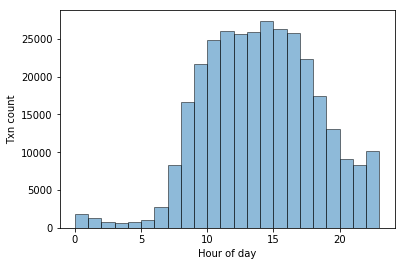

In [63]:
hod = users_orders_products_train_df['order_hour_of_day']
plt.hist(hod, bins=np.arange(hod.min(), hod.max()+1),alpha=0.5, histtype='bar', ec='black')
plt.xlabel('Hour of day');
plt.ylabel('Txn count');

### Distribution of number of products purchased by users

Text(0.5,0,'Number items in each txn')

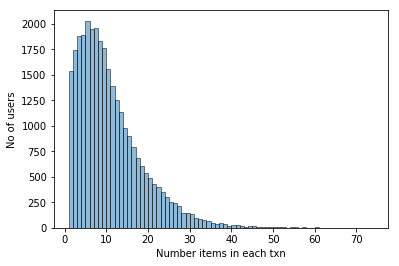

In [64]:
user_ids = users_orders_products_train_df['user_id']
user_counts = user_ids.value_counts()
user_counts = user_counts.tolist()

plt.hist(user_counts, bins=np.arange(min(user_counts), max(user_counts)+1),alpha=0.5, histtype='bar', ec='black')
plt.ylabel('No of users');
plt.xlabel('Number items in each txn')

### Most purchased products by users

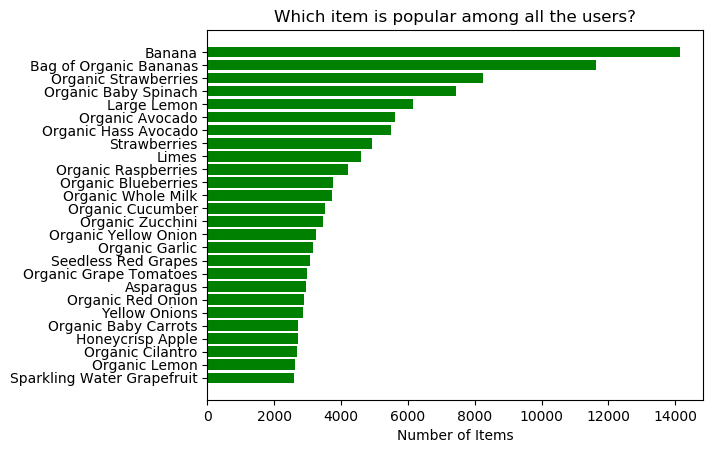

In [65]:
prod_ids = orders_products_train_df['product_id']
prod_counts = prod_ids.value_counts()
prod_counts = prod_counts[prod_counts>2500]

indexes = prod_counts.keys()
product = pd.Series()
product_label  = []
for idx in indexes:
    product_label.append(products_df.loc[products_df['product_id'] == idx, 'product_name'].values[0])
    
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(product_label))
ax.barh(y_pos,prod_counts,align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(product_label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Items')
ax.set_title('Which item is popular among all the users?')
plt.show()

In [66]:
order_dict = {}
for idx,order in orders_products_train_df.iterrows():
    if order['order_id'] in order_dict:
        order_dict[order['order_id']].append(products_df.loc[products_df['product_id']==order['product_id'],
                                                             'product_name'].values[0])       
    else:
        order_dict[order['order_id']] = [products_df.loc[products_df['product_id']==order['product_id'], 
                                                         'product_name'].values[0]]
    if idx == 50:
        break

mylist = []
for key,values in order_dict.items():
    mylist.append(values)
#print(list)
transaction_list = pd.DataFrame(mylist)
transaction_list = transaction_list.replace(np.nan, '', regex=True)
transaction_list.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Bulgarian Yogurt,Organic 4% Milk Fat Whole Milk Cottage Cheese,Organic Celery Hearts,Cucumber Kirby,Lightly Smoked Sardines in Olive Oil,Bag of Organic Bananas,Organic Hass Avocado,Organic Whole String Cheese,,,,,,,,,,,
1,Grated Pecorino Romano Cheese,Spring Water,Organic Half & Half,Super Greens Salad,Cage Free Extra Large Grade AA Eggs,"Prosciutto, Americano",Organic Garnet Sweet Potato (Yam),Asparagus,,,,,,,,,,,
2,Shelled Pistachios,Organic Biologique Limes,Organic Raw Unfiltered Apple Cider Vinegar,Organic Baby Arugula,Organic Hot House Tomato,Green Peas,Bunched Cilantro,"Flat Parsley, Bunch",Fresh Dill,,,,,,,,,,
3,Roasted Turkey,Organic Cucumber,Organic Grape Tomatoes,Organic Pomegranate Kernels,Organic Raspberries,Organic Whole Strawberries,Organic Blueberries,,,,,,,,,,,,
4,Natural Spring Water,Organic Orange Juice With Calcium & Vitamin D,Whole Milk Greek Blended Vanilla Bean Yogurt,Bag of Organic Bananas,Organic Chocolate Almondmilk Pudding,Organic Sliced Provalone Cheese,"Tomatoes, Crushed, Organic",Organic Unsweetened Almond Milk,"Crackers, Oyster",Uncured Applewood Smoked Bacon,Organic Seasoned Yukon Select Potatoes Hashed ...,Organic Extra Virgin Oil Olive,Organic Raspberries,Unsalted Cultured Butter,Guacamole,Black Beans,Raspberry Sorbet Pops,Geranium Liquid Dish Soap,Baby Swiss Slices Cheese


### Feature selection and one hot encoding on product_id and user_id columns to predict re-order flag

In [67]:
#Filter to just 50k transactions since original dataset is too large to process
users_orders_products_train_df = users_orders_products_train_df[users_orders_products_train_df.order_id <= 427531]

#feature_columns = ['order_id','product_id','add_to_cart_order','user_id','order_number','order_dow', 
#                   'order_hour_of_day','days_since_prior_order']
feature_columns = ['product_id','add_to_cart_order','user_id','order_dow', 
                   'order_hour_of_day','days_since_prior_order']

X = users_orders_products_train_df[feature_columns]
X = pd.get_dummies(X, columns=['product_id','user_id'])
y = users_orders_products_train_df['reordered']

print(X.shape)

(53158, 17480)


### Test, train data split and dimentionality reduction using PCA

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

pca = PCA(n_components=50)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape)

(42526, 50)


### Predict reorder flag using DecisionTreeClassifier and RandomForestClassifier

In [69]:
my_DT = DecisionTreeClassifier()

my_DT.fit(X_train, y_train)

y_predict_dt = my_DT.predict(X_test)

score_dt = accuracy_score(y_test, y_predict_dt)

print('Accuracy of reorder prediction using DecisionTree:', format(score_dt*100, '.2f'))

my_RF = RandomForestClassifier(n_estimators=25, bootstrap=True)

my_RF.fit(X_train, y_train)

y_predict_rf = my_RF.predict(X_test)

score_rf = accuracy_score(y_test, y_predict_rf)

print('Accuracy of reorder prediction using RandomForestClassifier:', format(score_rf*100, '.2f'))

Accuracy of reorder prediction using DecisionTree: 59.63
Accuracy of reorder prediction using RandomForestClassifier: 68.21


### Predict reorder flag using ANN

In [70]:
my_ANN = MLPClassifier(hidden_layer_sizes=(3,3), activation= 'logistic', 
                       solver='adam', alpha=1e-5, learning_rate_init = 0.01)

my_ANN.fit(X_train, y_train)

y_predict_ann = my_ANN.predict(X_test)

score_ann = accuracy_score(y_test, y_predict_ann)

print('Accuracy of reorder prediction using ANN(Layers=3,3):', format(score_ann*100, '.2f'))

Accuracy of reorder prediction using ANN(Layers=3,3): 63.81


### Grid search on ANN to find better Neuron count

In [71]:
# define a range for the "number of neurons" in the hidden layer for a network with 1 hidden layer:
neuron_number = [(i,j) for i in range(1,11) for j in range(1,11)]                    

# create a dictionary for grid parameter:
param_grid = dict(hidden_layer_sizes = neuron_number)
#print(param_grid,'\n')

# instantiate the model:
my_ANN = MLPClassifier(activation='logistic', solver='adam', alpha=1e-5, random_state=1, learning_rate_init = 0.01)

# creat the grid, and define the metric for evaluating the model: 
grid = GridSearchCV(my_ANN, param_grid, cv=10, scoring='accuracy')

X_ann_grid = pca.fit_transform(X)

# fit the grid (start the grid search):
grid.fit(X_ann_grid, y)

# view the results:
# print(grid.cv_results_)

# view the best results corresponding to the best structure of ANN:
print('Best accuracy with grid search:',grid.best_score_)
print('Number of nueral network layers for best accuracy:',grid.best_params_)

Best accuracy with grid search: 0.6356145829414199
Number of nueral network layers for best accuracy: {'hidden_layer_sizes': (5, 5)}


### Predict reorder using deep neural network

In [72]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=17480, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, y, epochs=3, batch_size=10000)

# evaluate the model
scores = model.evaluate(X, y)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/3
53158/53158 [==============================] - 54s 1ms/step - loss: 6.3049 - acc: 0.6045
Epoch 2/3
53158/53158 [==============================] - 53s 1000us/step - loss: 6.3049 - acc: 0.6045
Epoch 3/3
53158/53158 [==============================] - 43s 801us/step

acc: 60.45%


In [73]:
min_support = 10
min_confidence = 0.5

# References: https://www-users.cs.umn.edu/~kumar001/dmbook/ch6.pdf
#             https://en.wikipedia.org/wiki/Apriori_algorithm
def apriori(txn_set):
    '''
    Apriori algorithm implementation that returns the support and calculated association rules
    Returns:
        support    - dictionary of tuple of product ids and its calculated support value
        rules_list - List of calculated rules where each rule is a dictionary with lhs of rule,
                     rhs of rule and calculated confidence value for this rule.
    '''
    support_dict = {}
    itemset_dict = get_all_single_item_count(txn_set)
    support_dict = {**support_dict, **itemset_dict}
    txn_size = len(txn_set)
    while len(itemset_dict) > 0:
        c_k = get_candidate_itemsets(itemset_dict)
        if len(c_k) != 0:
            size, ht = build_hash_tree(c_k)
            for order_id in txn_set:
                item_list = txn_set[order_id]
                c_t = subset(size, ht, item_list)
                for c in c_t:
                    c_k[c] = c_k[c] + 1        
        #itemset_dict = {k: v for k, v in c_k.items() if v/txn_size >= min_support}
        itemset_dict = {k: v for k, v in c_k.items() if v >= min_support}
        support_dict = {**support_dict, **itemset_dict}        
        #print('candidate_set',c_k)
        #print('itemset_dict',itemset_dict)
        #print('support_dict',support_dict)
    return support_dict, apriori_genrules(support_dict)

def apriori_genrules(support_dict):
    '''
    Function that generates rules based on the support. If a rule like (a,b,c)->(d) has
    low confidence then the function skips processing all other rules (a,b)->(c,d)
    and (a)->(b,c,d) for efficiency.
    Confidence of each rule of form (a)->(b) is support(a)/support(b)
    '''
    rules_list = []
    for itemset_tuple in support_dict:
        itemset_list = list(itemset_tuple)
        itemset_size = len(itemset_list)
        if itemset_size >= 2:
            for i in range(itemset_size-1, 1, -1):
                lhs = tuple(itemset_list[0:i])
                rhs = tuple(itemset_list[i:itemset_size])
                conf = support_dict[itemset_tuple]/support_dict[lhs]
                if conf >= min_confidence:
                    rule_dict = {}
                    rule_dict['lhs'] = lhs
                    rule_dict['rhs'] = rhs
                    rule_dict['conf'] = conf
                    rules_list.append(rule_dict)
                else:
                    break
    return rules_list

def get_all_single_item_count(txn_set):
    '''
    Returns all unique product ids from transactions and the count of occurrence of
    each product where count of occurrence(support) is above the given min_support.
    '''
    itemset_count_dict = {}
    txn_size = len(txn_set)
    for order_id in txn_set:
        itemset = txn_set[order_id]
        for item in itemset:
            if item not in itemset_count_dict:
                itemset_count_dict[item] = 0
            itemset_count_dict[item] = itemset_count_dict[item] + 1
    #return {(k,): v for k, v in itemset_count_dict.items() if v/txn_size >= min_support}
    return {(k,): v for k, v in itemset_count_dict.items() if v >= min_support}

def get_candidate_itemsets(itemset_dict):
    '''
    Combines a given list of item set with itself and generated a new list as the candidate list
    Only items sets whose last item differ and all other last but one product ids are same are combined. 
    '''
    c_set = {}
    itemset_list = [k for k,v in itemset_dict.items()]
    itemset_size = len(itemset_list)
    for i in range(0, itemset_size-1):
        l1 = itemset_list[i]
        l1_len = len(l1)
        for j in range(i+1, itemset_size):
            l2 = itemset_list[j]
            l2_len = len(l2)
            if l1[0:l1_len-1] == l2[0:l2_len-1] and l1[-1] != l2[-1]:
                c = l1 + l2[-1:]
                c_set[tuple(sorted(c))] = 0
    return c_set
                
class Node:
    def __init__(self, key):
        self.key = key
        self.data = []
        self.children = {}
        
    def addData(self, d):
        self.data.append(d)
    
    def addChild(self, childKey):
        if childKey not in self.children:
            self.children[childKey] = Node(childKey)
        return self.children[childKey]
    
    def getChild(self, childKey):
        if childKey in self.children:
            return self.children[childKey]
        return None
    
    def isLeafNode(self):
        return len(self.children) == 0
    
    def nodeToString(self, indent):
        s = indent+'key:'+(str(self.key) if self.key is not None else 'None')+'\n'
        data = '),('.join(','.join(str(t) for t in d) for d in self.data)
        s = s+indent+'data:[('+data+')]\n'
        s = s+indent+'isLeafNode:'+str(self.isLeafNode())+'\n'
        l = len(self.children)
        if l==0:
            s=s+indent+'children:{}\n'
        else:
            s=s+indent+'children:{\n'
            for (key,val) in self.children.items():
                s=s+val.nodeToString(indent+'  ')
            s=s+indent+'}\n'
        return s
    
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
         return self.nodeToString('')
        
def build_hash_tree(c_k):
    '''
    Builds a hash tree with given candidate item set. The max number of branches at each level will be
    the size of the item set. mod(product_id, item_set_size) will assign the product id to its
    respective branch.
    '''
    hash_tree = {}
    size = 0
    for itemset in c_k:
        size = len(itemset)
        keyset = []
        for item in itemset:
            keyset.append(item % size)
        keyset = tuple(keyset)
        if keyset not in hash_tree:
            hash_tree[keyset] = []
        hash_tree[keyset].append(itemset)
    root = Node(None)
    for keyset in hash_tree:
        n = root
        for key in keyset:
            n = n.addChild(key)
        for itemset in hash_tree[keyset]:
            n.addData(itemset)        
    return size, root
      
def subset(size, ht, item_list):
    '''
    Returns all subset candidate item sets of a given item_list.
    This function that collects all possible subsets of given size in the bigger set item_list
    This function optimizes the subset generation with the knowledge of the minimum size of subset
    that should be generated. For example no of 3 item subsets of [1,2,3,4,5] are:
        123
        124
        125
        134
        135
        145
        234
        235
        245
        345
    Out of all possible subsets, the function only returns those that are part of the hash tree
    '''
    subset_tuple_list = []
    item_list = sorted(item_list)
    item_size = len(item_list)
    if(item_size >= size):
        comb_tuples = combinations(item_list, size)
        for comb_tuple in comb_tuples:
            node = ht
            for comb_item in comb_tuple:
                node = node.getChild(comb_item%size)
                if node is None:
                    break
            if node is not None and node.isLeafNode():
                if comb_tuple in node.data:
                    subset_tuple_list.append(comb_tuple)
    return subset_tuple_list

In [74]:
def prepare_txn_set():
    txn_set = {}
    for index, row in users_orders_products_train_df.iterrows():
        order_id = row['order_id']
        product_id = row['product_id']
        if order_id not in txn_set:
            txn_set[order_id] = []
        if product_id not in txn_set[order_id]:
            txn_set[order_id].append(product_id)
    return txn_set

In [75]:
txn_set = prepare_txn_set()
support, rules = apriori(txn_set)

#print(support)
#print(rules)

for r in rules:
    lhs = r['lhs']
    rhs = r['rhs']
    conf = r['conf']
    s = '{'
    for p in lhs:
        s = s + products_df[products_df['product_id'] == p].iloc[0]['product_name'] + ','
    s = s[:-1] + '} -> {'
    for p in rhs:
        s = s + products_df[products_df['product_id'] == p].iloc[0]['product_name'] + ','
    s = s[:-1] + '} : ' + str(format(conf, '.2f'))
    print(s)

{Limes,Bunched Cilantro} -> {Large Lemon} : 0.50
{Organic Red Bell Pepper,Banana} -> {Organic Avocado} : 0.58
{Broccoli Crown,Organic Strawberries} -> {Banana} : 0.55
{Seedless Red Grapes,Organic Baby Spinach} -> {Banana} : 0.50
{Limes,Asparagus} -> {Large Lemon} : 0.54
{Seedless Red Grapes,Limes} -> {Large Lemon} : 0.77
